In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
#plt.style.use('ggplot')

In [2]:
cuprum = pd.read_csv('data/VC-CUPRUM.csv', index_col=0, parse_dates=True)

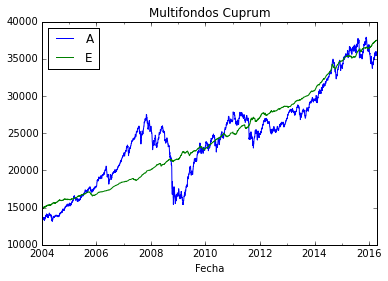

In [3]:
cuprum.loc['2004-01-01':,['A','E']].plot(title='Multifondos Cuprum')

In [4]:
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
cuprum['delta'] = cuprum.A - cuprum.E

In [5]:
# Zero es Nivel indiferencia arbitrario
# Parametros: ['median',365] (elejimos media movil 365)
cuprum['zero'] = cuprum.delta.rolling(window=365,center=False).median()
# Supuestos:
# Zero representa valor relativo fondo A comparable con E
# fondo E refugio A es como una pseudo Inverse exchange-traded cuando hay alta volatilidad
# Cambios entre renta variable (fondo A) y renta fija (fondo E)
# Estrategia objetivo "comprar barato y vender caro"
print "Describe zero:"
print cuprum.zero.describe()

Describe zero:
count    4641.000000
mean      -80.703038
std      2392.192696
min     -4225.140000
25%     -1735.930000
50%      -439.150000
75%      1282.620000
max      5582.000000
Name: zero, dtype: float64


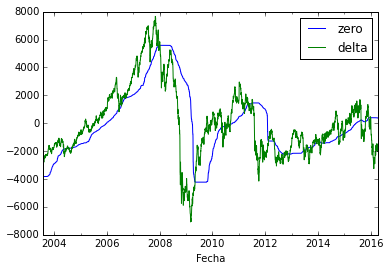

In [6]:
# Grafico de tendencia Delta diferencia entre A y E con nivel de indiferencia Zero
cuprum[['zero','delta']].dropna().plot()
# Observaciones:

# Se observa que hay una tendencia en que Delta converge a valor cercano a 0
# Cada vez es menos atractiva la estrategia de cambio de fondo entre A y E
# Pues variabilidad de Delta tienden a ser mas frecuentes y de menor aplitud

## Estrategias "ex post" (Basada en datos actuales en lugar de pronosticos)

# Estrategia "Evitar perdidas" (ejemplo: Felices y Forrados)
# Es muy dificil pues caidas son mas abruptas que subidas
# Consiste en mantenerse en A y refujiar en E implica aplicar "stop lost" algo muy dificil
# de implementar por la lentitud de los plazos cambio de fondo

# Estrategia propuesta "Aprovechar recuperacion"
# Dado que subida es mas lenta que caida mas acorde con lentitud de cambios de fondo 
# Consiste en mantenerse en E y despues de una gran caida entrar a A para aprovechar recuperacion
# implica aplicar un criterio arbitrario de "entrada" que define gran caida e inicio recuperacion

# Luego del periodo de recuperacion se sale de A mientras la probabilidad de recuperacion sea alta
# implica aplicar "stop gain" se debe elegir un criterio arbitrario de "salida"
# Criterios propuestos de salida:
# - Nivel de delta con probabilidad de recuraperacion acotada (tiene problema caso "recuperacion aparente")
# - Una rentabilidad objetivo proporcional a la reciente caida

# Dado que variaciones de delta tienden a ser mas frecuentes y de menor aplitud, esta estrategia
# tambien es cada vez mas dificil de implementar por la lentitud de cambios de fondo

# Estrategia dual "Evitar perdidas y Aprovechar recuperaciones"
# Entre el 2004 y el 2012 esta estrategia pudo aprovecharse ya que variacion tendencia de delta
# fue en ciclos grandes de gran amplitud
# A partir del 2012 variacion tendencia delta es de ciclos cortos y baja amplitud, por lo que
# solo la estrategia de aprovechar recuperacion es atractiva
# 

## Estrategias "ex ante" (Basada en pronósticos en lugar de datos actuales)

# En teoria se podria hacer ambas estrategias evitar caidas del A y aprovechar recuperaciones del A, 
# Si se pudiera "predecir" cambios de tendencia en los mercados en el mediano plazo seria factible, pero
# Nadie a demostrato un metodo consistente para lograr eso

In [7]:
# Probabilidad (baja) ganancia A cuando valor de A es relativamente mas caro que E => delta > zero (baja)
# Probabilidad (alta) ganancia A cuando valor de A es relativamente mas barato que E => delta < zero (alta)
cuprum['earnA'] = pd.np.where(cuprum['delta'] < cuprum['zero'], 'alta', 'baja')
cuprum['alta'] = cuprum.delta[cuprum.delta<cuprum.zero]
cuprum['baja'] = cuprum.delta[cuprum.delta>cuprum.zero]

# Luego de una caida de A la probabilidad de ganacia A es alta (recuperacion)
# pues se supone que renta variable en promedio genera mas valor que renta fija

# Warning: "Probabilidad de ganancia A" != 1-"Probabilidad de perdida de A"
# Antes de grandes caidas, hay mucha volatilidad con recuperaciones "aparentes"
# que preceden grandes caidas, por eso es necesario ademas tener datos de riesgo sistemico

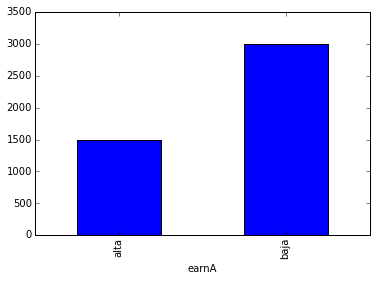

In [8]:
# Cuenta dias en que probabilidad de ganacia es alta y baja
cuprum['2004-01-01':].groupby('earnA').count()['delta'].plot(kind='bar')
# Del grafico se puede obserbar que eventos con probabilidad ganancia A son menos frecuentes
# Posibles estrategias:
# Mantener siempre en fondo E 
# Entonces si nos mantenemos en E y aprovechamos ciertos eventos de recuperacion

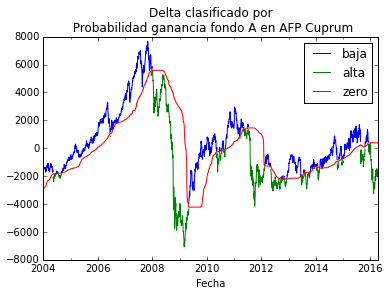

In [9]:
cuprum.loc['2004-01-01':,['baja','alta','zero']].plot(title='Delta clasificado por \n Probabilidad ganancia fondo A en AFP Cuprum')

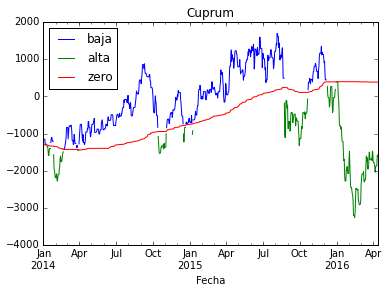

In [10]:
# Zoom desde año 2014 al presente
cuprum.loc['2014-01-01':,['baja','alta','zero']].plot(title='Cuprum')

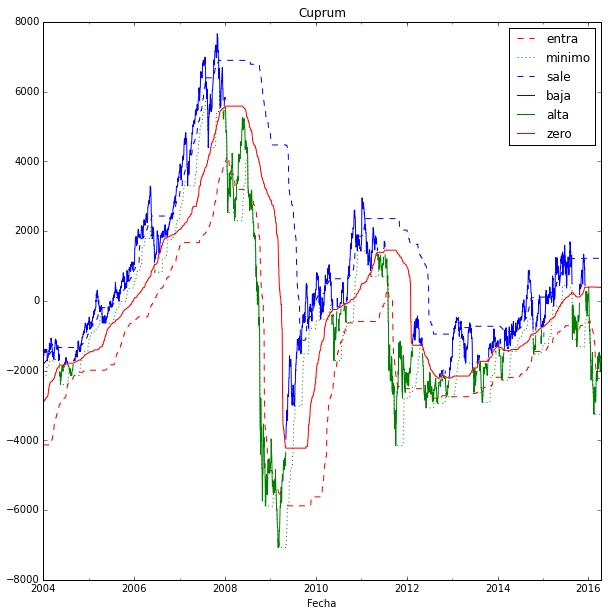

In [11]:
## Estrategia "Aprovechar recuperacion" y "Evitar perdidas" con stop gain
# Criterios de Entrada
# Parametros: ['quantile',0.1,365] (elejimos cuantil 10% ventana 365)
# min < delta =~ entra 
# Criterios de Salida
# Parametros: ['quantile',0.85,365] (elejimos cuantil 85% ventana 365)

cuprum['rate'] = cuprum.delta.pct_change(15)
cuprum['entra'] = cuprum.delta.rolling(window=365,center=False).quantile(quantile=0.1)
cuprum['minimo'] = cuprum.delta.rolling(window=60,center=False).min()
cuprum['sale'] = cuprum.delta.rolling(window=365,center=False).quantile(quantile=0.9)
ax = cuprum.loc['2004-01-01':,['entra','minimo','sale']].plot(title='Cuprum', style=['--r',':g','--b'])
cuprum.loc['2004-01-01':,['baja','alta','zero']].plot(title='Cuprum', figsize=(10,10), style=['b','g','r'], ax=ax)

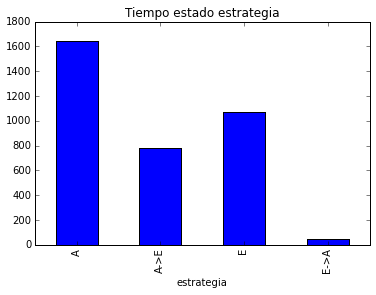

In [12]:
# Definicion reglas de la estrategia
cuprum.loc[cuprum.delta < cuprum.entra,'estrategia'] = 'E'
cuprum.loc[(cuprum.delta > cuprum.entra) & (cuprum.delta < cuprum.zero) & (cuprum.rate > 1),'estrategia'] = 'E->A'
cuprum.loc[(cuprum.delta > cuprum.entra) & (cuprum.delta < cuprum.zero) & (cuprum.rate < 0),'estrategia'] = 'E'
cuprum.loc[(cuprum.delta > cuprum.zero) & (cuprum.delta < cuprum.sale),'estrategia'] = 'A'
cuprum.loc[(cuprum.delta > cuprum.sale) & (cuprum.rate < 0),'estrategia'] = 'A->E'
cuprum.loc[(cuprum.delta > cuprum.sale) & (cuprum.rate > 1),'estrategia'] = 'A'
cuprum.groupby('estrategia').count()['zero'].plot(kind='bar', title='Tiempo estado estrategia')

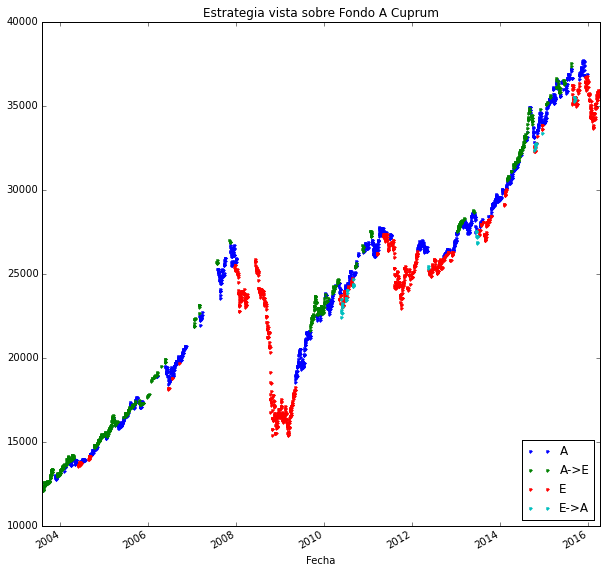

In [13]:
# Se observa que esta estrategia mas conservadora momento de cambio de A -> E 
cuprum.groupby('estrategia').A.plot(style='.', figsize=(10,10), title='Estrategia vista sobre Fondo A Cuprum')
plt.legend(loc=4)

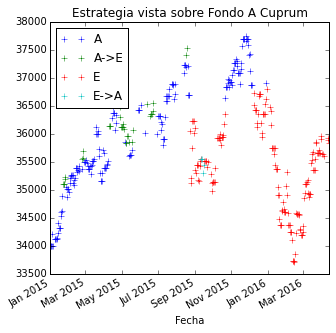

In [14]:
# Se observa que esta estrategia mas conservadora momento de cambio de A -> E 
cuprum['2015':].groupby('estrategia').A.plot(style='+', figsize=(5,5), title='Estrategia vista sobre Fondo A Cuprum')
plt.legend(loc=2)

In [15]:
# Ultimas 15 dias de estrategia
cuprum.iloc[-15:][['A','E','estrategia']]

,A,E,estrategia
Fecha,,,
2016-03-30,35959.36,37434.40,E
2016-03-31,35907.09,37410.61,E
2016-04-01,35646.04,37416.03,NaN
2016-04-02,35646.04,37416.03,E
2016-04-03,35646.04,37416.03,E
2016-04-04,35600.77,37449.91,E
2016-04-05,35544.27,37442.75,NaN
2016-04-06,35422.37,37457.43,NaN
2016-04-07,35591.71,37493.58,NaN


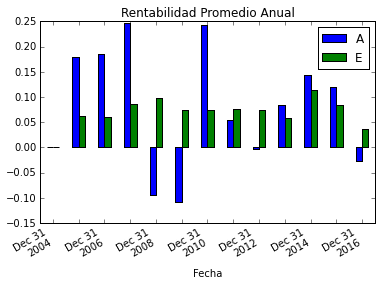

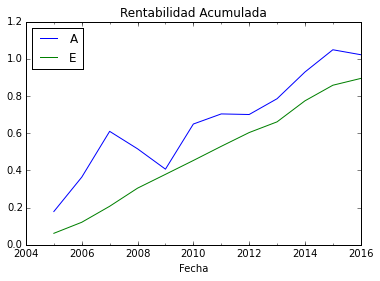

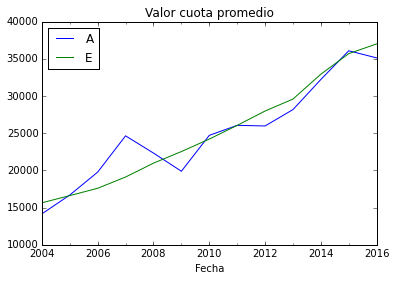

In [16]:
# Grafico rentabilidad, rentabilidad acumulada y valor cuota promedio periodo
# Periodos : W week, , M month, Q quarter, A year
period = 'A'
# Promedio del periodo
df = cuprum.loc['2004-01-01':,['A','E']].resample(period).mean()
# Grafo rentabilidad
aux = df.pct_change(1)
ax = aux.plot(title='Rentabilidad Promedio Anual', kind='bar')
# Fix date format on bar plot with pandas
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(df.index)
show = 6; step = int(len(df.index)/show)
# Every step ticklable shows the month, day and year
ticklabels[::step] = [item.strftime('%b %d\n%Y') for item in aux.index[::step]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
# Grafo rentabilidad acumulada
df.pct_change(1).cumsum().plot(title='Rentabilidad Acumulada')
# Grafo valor cuota promedio
df.plot(title='Valor cuota promedio')

In [17]:
# Indicadores de Riesgo sistemico
dow = pd.read_csv('data_quandl/dow.csv', index_col=0, parse_dates=True)
wti = pd.read_csv('data_quandl/wti.csv', index_col=0, parse_dates=True)
fedrate = pd.read_csv('data_quandl/fedrate.csv', index_col=0, parse_dates=True)
usdclp = pd.read_csv('data_quandl/usdclp.csv', index_col=0, parse_dates=True)

In [18]:
df = pd.DataFrame()
df['dow'] = dow.Value
df['A'] = cuprum.A
df['wti'] = wti.Value
df['fed'] = fedrate.FEDFUNDS.resample('D').bfill()
df['usdclp'] = usdclp.Rate

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010AF3CC0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000124BBFD0>], dtype=object)

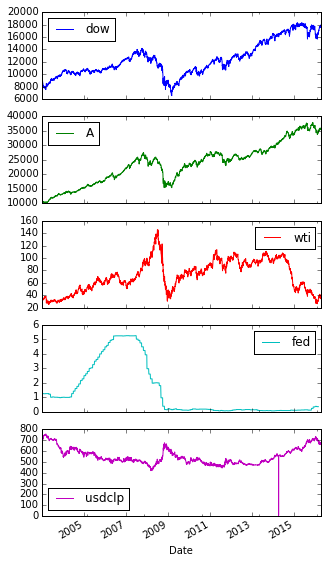

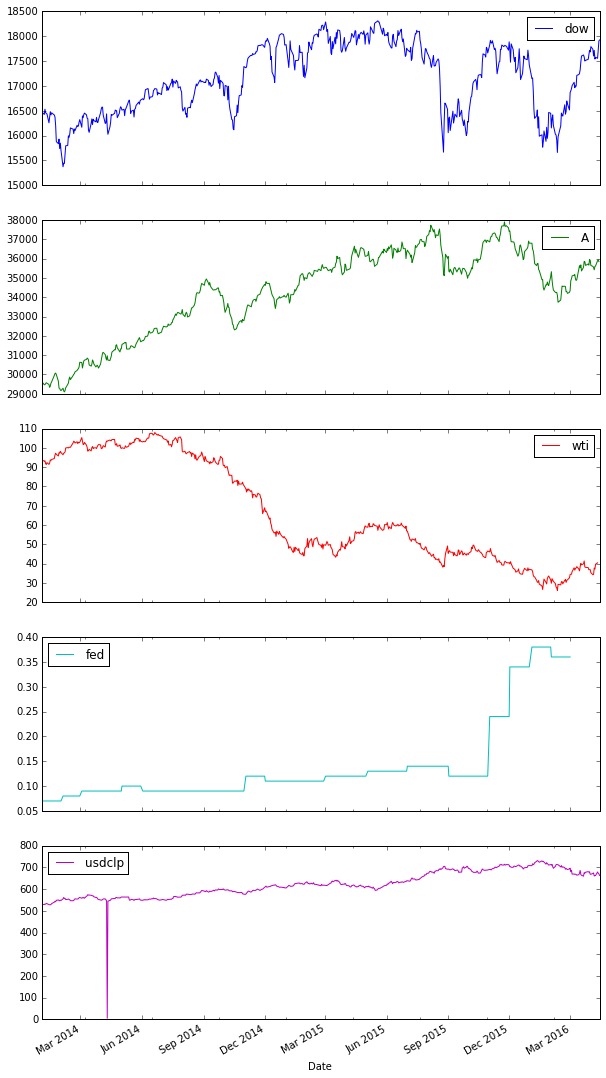

In [19]:
df['2003':].plot(subplots=True, figsize=(5, 10), sharex=True)
df['2014':].plot(subplots=True, figsize=(10, 20), sharex=True)

In [20]:
#%qtconsole